In [199]:
# packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, precision_score

from matplotlib import pyplot as plt

In [200]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [221]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [222]:
columns_keep = ['redispatch', 'level',
                'wind_gust_max_m/s',
                'wind_gust_max_m/s_lag1',
                'wind_gust_max_m/s_lag2',
                'wind_gust_max_m/s_lag3',
                'air_temperature_K_lag3',
                'wind_direction_degrees',
                'wind_direction_degrees_lag1',
                'wind_direction_degrees_lag2',
                'wind_direction_degrees_lag3',
                'wind_direction_gust_max_degrees',
                'wind_direction_gust_max_degrees_lag1',
                'wind_direction_gust_max_degrees_lag2',
                'wind_direction_gust_max_degrees_lag3',
                'humidity_percent_lag3']
df = df[columns_keep]

In [179]:
df.columns

Index(['redispatch', 'wind_direction_degrees', 'wind_direction_degrees_lag1',
       'wind_direction_degrees_lag2', 'air_temperature_K',
       'air_temperature_K_lag1', 'air_temperature_K_lag2',
       'air_temperature_K_lag3', 'wind_gust_max_m/s', 'wind_gust_max_m/s_lag1',
       'wind_gust_max_m/s_lag2', 'wind_gust_max_m/s_lag3',
       'wind_direction_gust_max_degrees',
       'wind_direction_gust_max_degrees_lag1',
       'wind_direction_gust_max_degrees_lag2', 'pumped_storage_MWh',
       'humidity_percent', 'humidity_percent_lag3'],
      dtype='object')

In [223]:
# Drop the rows to get appropriate test data
start_date = '2022-01-01'
end_date = '2023-11-14'
df = df.loc[start_date:end_date]

In [286]:
# preprocessing pipelines
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# create model instance
xgboost_class = XGBClassifier(booster='gbtree', reg_alpha=0, eval_metric='logloss', #gamma = 1,
                              n_estimators=100, max_depth=2, learning_rate=0.1, objective='binary:logistic', random_state = 13, scale_pos_weight=14)

# reg_alpha = introduces L1 regularization
# gamma = minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be
# scale_pos_weights =

# features X and target y
X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

0.0    40
1.0     8
Name: redispatch, dtype: int64
0.0    29
1.0    19
Name: redispatch, dtype: int64
1.0    36
0.0    12
Name: redispatch, dtype: int64
0.0    46
1.0     2
Name: redispatch, dtype: int64
0.0    45
1.0     3
Name: redispatch, dtype: int64
1.0    40
0.0     8
Name: redispatch, dtype: int64
1.0    34
0.0    14
Name: redispatch, dtype: int64
0.0    42
1.0     6
Name: redispatch, dtype: int64
0.0    39
1.0     9
Name: redispatch, dtype: int64
0.0    30
1.0    18
Name: redispatch, dtype: int64
0.0    47
1.0     1
Name: redispatch, dtype: int64
0.0    47
1.0     1
Name: redispatch, dtype: int64
Average Recall: 0.6527777777777778
Average Accuracy: 0.501736111111111
Average Confusion Matrix: [[14.5        18.75      ]
 [ 5.16666667  9.58333333]]


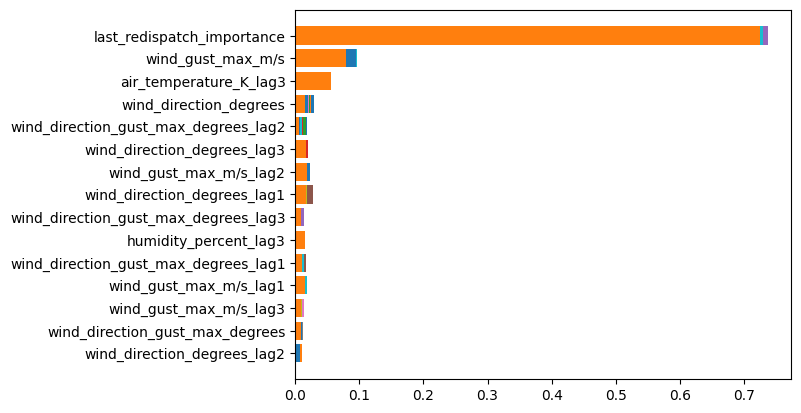

In [287]:
# cross-validation
n_splits = 70
test_size = 48 #(12h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

recall_scores = []
accuracy_scores = []
conf_matrices = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = X_train.copy()
    X_test = X_test.copy()

    # check if at least one instance of redispatch with status 1 is present in the test data
    if y_test.sum() == 0:
        continue

    # importance of the last redispatch status for the training data
    window_size = 2  # last 30 min
    last_redispatch_importance_train = []
    for i in range(len(y_train)):
        window_start = max(0, i - window_size)
        window_end = i
        importance = y_train.iloc[window_start:window_end].sum() # also incorporate the level
        last_redispatch_importance_train.append(importance)
    X_train['last_redispatch_importance'] = last_redispatch_importance_train

    # rate of decrease for the importance values
    decrease_rate = last_redispatch_importance_train[-1] / len(X_test)

    # forward fill the last value of 'last_redispatch_importance' for the test data with exponentially decreasing values
#    last_redispatch_importance_test = np.linspace(last_redispatch_importance_train[-1], 0, len(X_test))
#    X_test['last_redispatch_importance'] = last_redispatch_importance_test

    decay_factor = 0.9
    last_redispatch_importance_test = [last_redispatch_importance_train[-1] * (decay_factor ** i) for i in range(len(X_test))]
    X_test['last_redispatch_importance'] = last_redispatch_importance_test

    # Preprocess and oversample only the training data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)

    # Preprocess the test data
    X_test_preprocessed = preprocessor.transform(X_test)

    # fit model
    xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)

    # make predictions
    y_pred = xgboost_class.predict(X_test_preprocessed)

    print(y_test.value_counts())
    #print("last redispatch importance: ", X_test['last_redispatch_importance'])

    recall_scores.append(recall_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    sorted_idx = xgboost_class.feature_importances_.argsort()
    plt.barh(X_train.columns[sorted_idx], xgboost_class.feature_importances_[sorted_idx])

    #saving the plot as a png file
    #plt.savefig('feature_importance_xgboost.png')


# evaluate
print("Average Recall:", sum(recall_scores) / len(recall_scores))
print("Average Accuracy:", sum(accuracy_scores) / len(accuracy_scores))
print("Average Confusion Matrix:", sum(conf_matrices) / len(conf_matrices))

In [ ]:
#xgboost_class = XGBClassifier(booster='gbtree', reg_alpha=0, eval_metric='logloss', gamma = 1, # reg_alpha introduces L1 regularization
#                              n_estimators=100, max_depth=4, learning_rate=0.1, objective='binary:logistic', random_state = 13, scale_pos_weight=2)


0.0    40
1.0     8
Name: redispatch, dtype: int64
0.0    29
1.0    19
Name: redispatch, dtype: int64
1.0    36
0.0    12
Name: redispatch, dtype: int64
0.0    46
1.0     2
Name: redispatch, dtype: int64
0.0    45
1.0     3
Name: redispatch, dtype: int64
1.0    40
0.0     8
Name: redispatch, dtype: int64
1.0    34
0.0    14
Name: redispatch, dtype: int64
0.0    42
1.0     6
Name: redispatch, dtype: int64
0.0    39
1.0     9
Name: redispatch, dtype: int64
0.0    30
1.0    18
Name: redispatch, dtype: int64
0.0    47
1.0     1
Name: redispatch, dtype: int64
0.0    47
1.0     1
Name: redispatch, dtype: int64
Average Recall: 0.7923611111111111
Average Accuracy: 0.4375
Average Confusion Matrix: [[ 9.66666667 23.58333333]
 [ 3.41666667 11.33333333]]


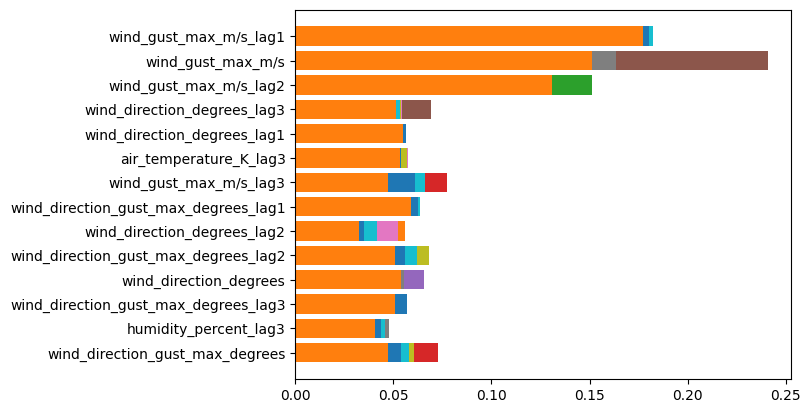

In [275]:
# cross-validation
n_splits = 70
test_size = 48 #(12h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

recall_scores = []
accuracy_scores = []
conf_matrices = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = X_train.copy()
    X_test = X_test.copy()

    # check if at least one instance of redispatch with status 1 is present in the test data
    if y_test.sum() == 0:
        continue
    '''
    # importance of the last redispatch status for the training data
    window_size = 2  # last 30 min
    last_redispatch_importance_train = []
    for i in range(len(y_train)):
        window_start = max(0, i - window_size)
        window_end = i
        importance = y_train.iloc[window_start:window_end].sum() # also incorporate the level
        last_redispatch_importance_train.append(importance)
    X_train['last_redispatch_importance'] = last_redispatch_importance_train

    # rate of decrease for the importance values
    decrease_rate = last_redispatch_importance_train[-1] / len(X_test)

    # forward fill the last value of 'last_redispatch_importance' for the test data with decreasing values
    last_redispatch_importance_test = np.linspace(last_redispatch_importance_train[-1], 0, len(X_test))
    X_test['last_redispatch_importance'] = last_redispatch_importance_test
    '''
    # Preprocess and oversample only the training data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)

    # Preprocess the test data
    X_test_preprocessed = preprocessor.transform(X_test)

    # fit model
    xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)

    # make predictions
    y_pred = xgboost_class.predict(X_test_preprocessed)

    print(y_test.value_counts())
    #print("last redispatch importance: ", X_test['last_redispatch_importance'])

    recall_scores.append(recall_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    sorted_idx = xgboost_class.feature_importances_.argsort()
    plt.barh(X_train.columns[sorted_idx], xgboost_class.feature_importances_[sorted_idx])

    #saving the plot as a png file
    plt.savefig('feature_importance_xgboost.png')


# evaluate
print("Average Recall:", sum(recall_scores) / len(recall_scores))
print("Average Accuracy:", sum(accuracy_scores) / len(accuracy_scores))
print("Average Confusion Matrix:", sum(conf_matrices) / len(conf_matrices))

In [264]:
from sklearn.model_selection import GridSearchCV

# Preprocess and oversample only the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)

# Preprocess the test data
X_test_preprocessed = preprocessor.transform(X_test)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5]
}

# Create XGBClassifier instance
xgboost_class = XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic', random_state=13)

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=xgboost_class, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train_preprocessed, y_train_preprocessed)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
'''
# Define the cross-validation strategy
n_splits = 16
test_size = 24  # 6h with 15 min intervals
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Define scoring metrics
scoring = {'recall': make_scorer(recall_score)}

# Perform cross-validation
recall_scores = cross_val_score(xgboost_class, X_train_preprocessed, y_train_preprocessed,
                                cv=tscv, scoring=scoring['recall'])

# Calculate the average recall score
average_recall = np.mean(recall_scores)
print("Average Recall Score with L1 regularization:", average_recall)
'''

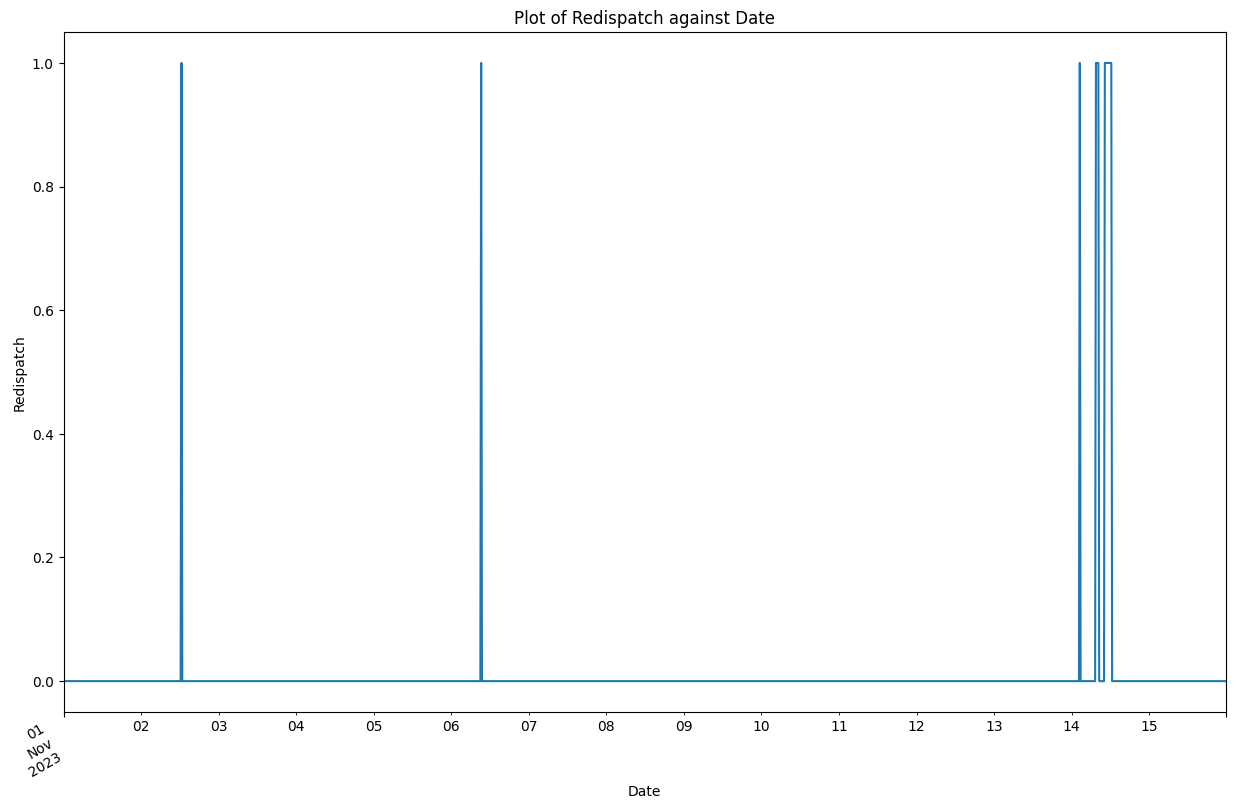

In [ ]:
# Plot the column against the datetime index
start_date = '2023-11-01'
end_date = '2023-11-15'

# Plot the data
ax = df.loc[start_date:end_date, 'redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format and limits
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch against Date')

# Show the plot
plt.show()